Câu 3 – Minibatch SGD with vs without replacement:

Khi chuyển minibatch SGD sang sampling with replacement, thuật toán vẫn hội tụ, nhưng loss theo epoch nhiễu hơn một chút do có batch lặp lại mẫu nhiều lần và có mẫu chưa được dùng trong epoch.

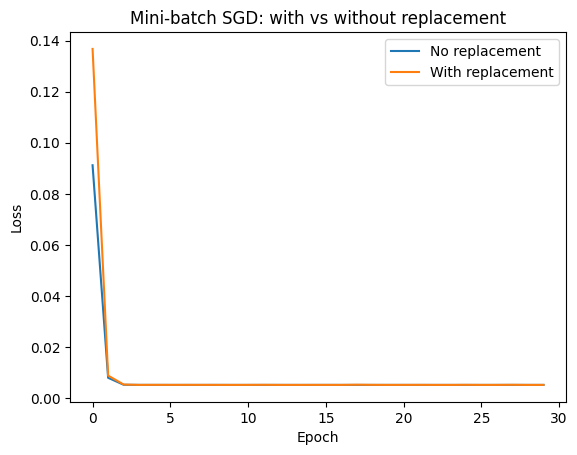

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Tạo dữ liệu hồi quy tuyến tính đơn giản
def make_data(n_samples=1000):
    X = np.random.randn(n_samples, 1)
    true_w, true_b = 2.0, -1.0
    y = true_w * X[:, 0] + true_b + 0.1 * np.random.randn(n_samples)
    return X, y

X, y = make_data(500)

def mse_loss(X, y, w, b):
    y_pred = X @ w + b
    return np.mean((y_pred[:,0] - y)**2) / 2.0

def minibatch_without_replacement(X, y, w0, b0, lr=0.1, batch_size=32, epochs=20):
    n = X.shape[0]
    w, b = w0.copy(), b0
    losses = []
    for epoch in range(epochs):
        indices = np.random.permutation(n)            # KHÔNG hoàn lại
        for start in range(0, n, batch_size):
            batch_idx = indices[start:start+batch_size]
            xb = X[batch_idx]
            yb = y[batch_idx]
            y_pred = xb @ w + b
            grad_w = (xb.T @ (y_pred[:,0] - yb)) / len(xb)
            grad_b = np.mean(y_pred[:,0] - yb)
            w -= lr * grad_w.reshape(-1,1)
            b -= lr * grad_b
        losses.append(mse_loss(X, y, w, b))
    return w, b, losses

def minibatch_with_replacement(X, y, w0, b0, lr=0.1, batch_size=32, epochs=20):
    n = X.shape[0]
    w, b = w0.copy(), b0
    losses = []
    for epoch in range(epochs):
        num_batches = n // batch_size                 # xấp xỉ số batch / epoch
        for _ in range(num_batches):
            batch_idx = np.random.choice(n, size=batch_size, replace=True)  # CÓ hoàn lại
            xb = X[batch_idx]
            yb = y[batch_idx]
            y_pred = xb @ w + b
            grad_w = (xb.T @ (y_pred[:,0] - yb)) / len(xb)
            grad_b = np.mean(y_pred[:,0] - yb)
            w -= lr * grad_w.reshape(-1,1)
            b -= lr * grad_b
        losses.append(mse_loss(X, y, w, b))
    return w, b, losses

# Chạy thử
w0 = np.zeros((1,1))
b0 = 0.0
w_nr, b_nr, loss_nr = minibatch_without_replacement(X, y, w0, b0, lr=0.1, batch_size=32, epochs=30)
w_wr, b_wr, loss_wr = minibatch_with_replacement(X, y, w0, b0, lr=0.1, batch_size=32, epochs=30)

plt.figure()
plt.plot(loss_nr, label="No replacement")
plt.plot(loss_wr, label="With replacement")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mini-batch SGD: with vs without replacement")
plt.legend()
plt.show()


Câu 4 – “Evil genie” nhân đôi dataset

Đề bài: nhân đôi dataset (mỗi mẫu xuất hiện 2 lần). Hỏi behavior của:

*   Gradient Descent (hay GD)
*   Stochastic Gradient Descent (SGD)
*   Mini-Batch SGD


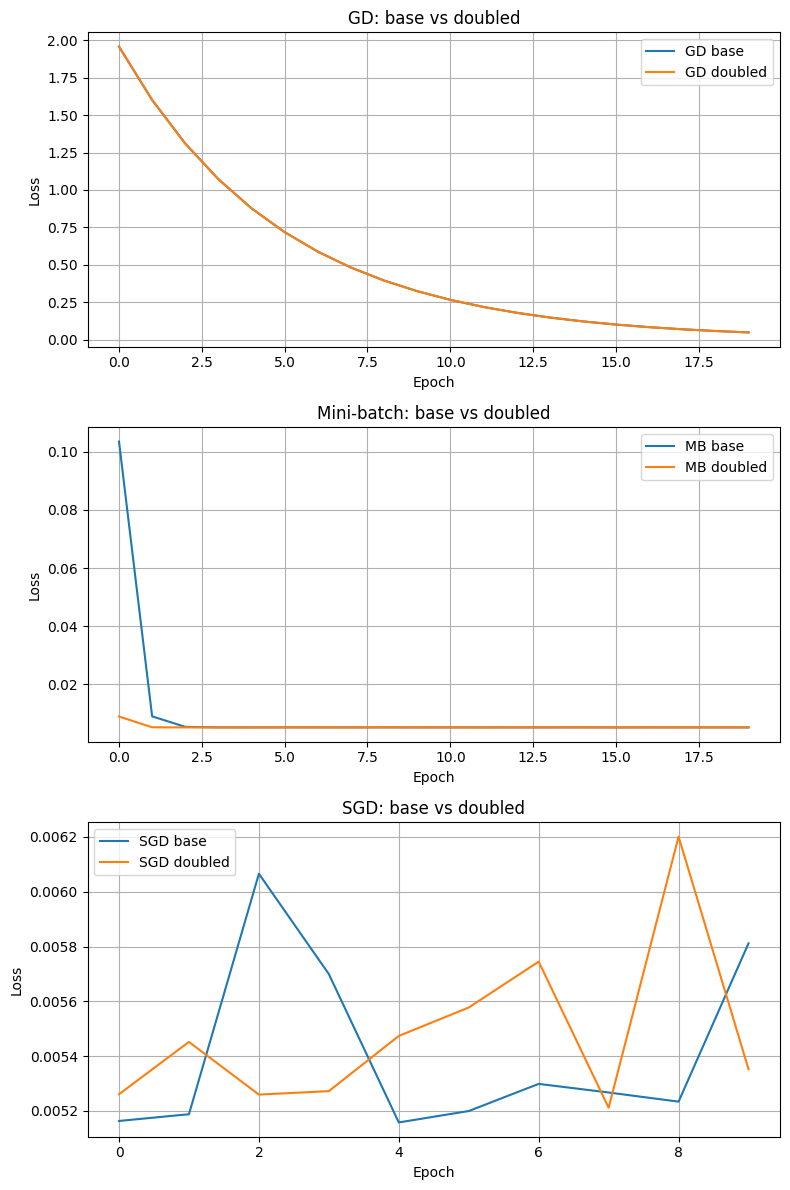

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ==== DATA GENERATION ====
def make_data(n_samples=1000):
    X = np.random.randn(n_samples, 1)
    true_w, true_b = 2.0, -1.0
    y = true_w * X[:, 0] + true_b + 0.1 * np.random.randn(n_samples)
    return X, y

def mse_loss(X, y, w, b):
    y_pred = X @ w + b
    return np.mean((y_pred[:,0] - y)**2) / 2.0

# ==== TRAINING LOOPS ====
def train_gd(X, y, lr=0.1, epochs=20):
    n, d = X.shape
    w = np.zeros((d,1))
    b = 0.0
    losses = []
    for epoch in range(epochs):
        y_pred = X @ w + b
        grad_w = (X.T @ (y_pred[:,0] - y)) / n
        grad_b = np.mean(y_pred[:,0] - y)
        w -= lr * grad_w.reshape(-1,1)
        b -= lr * grad_b
        losses.append(mse_loss(X, y, w, b))
    return w, b, losses

def train_sgd(X, y, lr=0.1, epochs=5):
    n, d = X.shape
    w = np.zeros((d,1))
    b = 0.0
    losses = []
    for epoch in range(epochs):
        indices = np.random.permutation(n)
        for i in indices:
            xb = X[i:i+1]
            yb = y[i:i+1]
            y_pred = xb @ w + b
            grad_w = xb.T @ (y_pred[:,0] - yb)
            grad_b = np.mean(y_pred[:,0] - yb)
            w -= lr * grad_w.reshape(-1,1)
            b -= lr * grad_b
        losses.append(mse_loss(X, y, w, b))
    return w, b, losses

def minibatch_without_replacement(X, y, w0, b0, lr=0.1, batch_size=32, epochs=20):
    n = X.shape[0]
    w, b = w0.copy(), b0
    losses = []
    for epoch in range(epochs):
        indices = np.random.permutation(n)
        for start in range(0, n, batch_size):
            batch_idx = indices[start:start+batch_size]
            xb = X[batch_idx]
            yb = y[batch_idx]
            y_pred = xb @ w + b
            grad_w = (xb.T @ (y_pred[:,0] - yb)) / len(xb)
            grad_b = np.mean(y_pred[:,0] - yb)
            w -= lr * grad_w.reshape(-1,1)
            b -= lr * grad_b
        losses.append(mse_loss(X, y, w, b))
    return w, b, losses

def train_minibatch(X, y, lr=0.1, batch_size=32, epochs=20):
    w0 = np.zeros((X.shape[1],1))
    b0 = 0.0
    return minibatch_without_replacement(X, y, w0, b0, lr, batch_size, epochs)

# ==== DATA ====
X_base,  y_base  = make_data(500)
X_double = np.concatenate([X_base, X_base], axis=0)
y_double = np.concatenate([y_base, y_base], axis=0)

# ==== TRAIN ====
w_gd_base, b_gd_base, loss_gd_base = train_gd(X_base, y_base, lr=0.1, epochs=20)
w_sgd_base, b_sgd_base, loss_sgd_base = train_sgd(X_base, y_base, lr=0.05, epochs=10)
w_mb_base,  b_mb_base,  loss_mb_base  = train_minibatch(X_base, y_base, lr=0.1, batch_size=32, epochs=20)

w_gd_dbl, b_gd_dbl, loss_gd_dbl = train_gd(X_double, y_double, lr=0.1, epochs=20)
w_sgd_dbl, b_sgd_dbl, loss_sgd_dbl = train_sgd(X_double, y_double, lr=0.05, epochs=10)
w_mb_dbl,  b_mb_dbl,  loss_mb_dbl  = train_minibatch(X_double, y_double, lr=0.1, batch_size=32, epochs=20)

# ==== PLOTS ====
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# GD
axes[0].plot(loss_gd_base, label="GD base")
axes[0].plot(loss_gd_dbl, label="GD doubled")
axes[0].set_title("GD: base vs doubled")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

# Mini-batch
axes[1].plot(loss_mb_base, label="MB base")
axes[1].plot(loss_mb_dbl, label="MB doubled")
axes[1].set_title("Mini-batch: base vs doubled")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)

# SGD
axes[2].plot(loss_sgd_base, label="SGD base")
axes[2].plot(loss_sgd_dbl, label="SGD doubled")
axes[2].set_title("SGD: base vs doubled")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Loss")
axes[2].legend()
axes[2].grid(True)

fig.tight_layout()
plt.show()
